This notebook is the 2nd of a notebook series for Healthcom 2020. It describes our methods for binary prediction of colorectal cancer recurrence using synthetic datasets.  
We include a description of the synthetic datasets, as well as code for our models.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
from tsfresh import extract_relevant_features

/home/dlho/Software/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Dataset description and exploration

In [2]:
tabulardf = pd.read_csv("synthetic_structured.csv")
tsdf = pd.read_csv("synthetic_ts.csv")

We explore the synthetic datasets. The tabular dataset consists of:  
1 quantitative variable (age_at_diagnosis)  
10 categorical features  
the outcome feature (relapse, as well as relapse_date)

### Tabular dataset exploration

In [3]:
tabulardf.head()

,patient_id,age_at_diagnosis,gender,race,tumour_site,t,n,msi_status,kras,braf,main_surgery,chemotherapy,relapse,relapse_date
0,1,61.118370,female,chinese,sigmoid,t3,n2,mss,positive,negative,colectomy,folfox,yes,2022-01-01
1,2,62.334809,female,chinese,rectum,t2,n1,mss,positive,positive,colectomy,xeloda,no,NaN
2,3,60.498836,male,malay,sigmoid,t3,n2,mss,positive,negative,others,xelox,no,NaN
3,4,58.600136,male,chinese,others,t1,n2,mss,negative,positive,laparoscopy,xeloda,no,NaN
4,5,64.741463,male,chinese,sigmoid,t3,n1,mss,positive,negative,others,xeloda,no,NaN


In [4]:
tabulardf.describe(include='all')

,patient_id,age_at_diagnosis,gender,race,tumour_site,t,n,msi_status,kras,braf,main_surgery,chemotherapy,relapse,relapse_date
count,900.000000,900.000000,900,900,900,900,900,900,900,900,900,900,900,231
unique,NaN,NaN,2,4,3,3,3,2,2,2,3,4,2,1
top,NaN,NaN,female,chinese,sigmoid,t3,n2,mss,negative,negative,colectomy,xelox,no,2022-01-01
freq,NaN,NaN,522,648,368,331,382,657,469,727,533,283,669,231
mean,450.500000,60.095931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,259.951919,5.025774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,42.429602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,225.750000,56.679513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,450.500000,60.057776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,675.250000,63.260756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
quantitative_features = ['age_at_diagnosis']
categorical_features = ['gender', 'race', 'tumour_site', 't', 'n', 'msi_status', 'kras', 'braf', 'main_surgery', 'chemotherapy']
for feature in categorical_features:
    print(tabulardf[feature].value_counts(normalize=True)) # Relative proportions of each categorical variable

female    0.58
male      0.42
Name: gender, dtype: float64
chinese    0.720000
malay      0.178889
indian     0.085556
others     0.015556
Name: race, dtype: float64
sigmoid    0.408889
rectum     0.394444
others     0.196667
Name: tumour_site, dtype: float64
t3    0.367778
t1    0.320000
t2    0.312222
Name: t, dtype: float64
n2    0.424444
n1    0.310000
n3    0.265556
Name: n, dtype: float64
mss    0.73
msi    0.27
Name: msi_status, dtype: float64
negative    0.521111
positive    0.478889
Name: kras, dtype: float64
negative    0.807778
positive    0.192222
Name: braf, dtype: float64
colectomy      0.592222
laparoscopy    0.318889
others         0.088889
Name: main_surgery, dtype: float64
xelox     0.314444
xeloda    0.274444
folfox    0.217778
others    0.193333
Name: chemotherapy, dtype: float64


In [6]:
# Checking for null values 
tabulardf.isnull().sum() # Null values only occur in the relapse date. There is no date if the patient did not relapse. Since it is not our predictor variable, it is ok.

patient_id            0
age_at_diagnosis      0
gender                0
race                  0
tumour_site           0
t                     0
n                     0
msi_status            0
kras                  0
braf                  0
main_surgery          0
chemotherapy          0
relapse               0
relapse_date        669
dtype: int64

### Time-series dataset exploration

In [7]:
tsdf.head()

,timestamps,cea,patient_id
0,2020-08-01,0.359474,1
1,2020-09-01,0.485895,1
2,2020-10-01,0.871115,1
3,2020-10-31,0.871115,1
4,2020-12-01,1.663848,1


It has multiple timestamps for each patient, with a reading for CEA at each timestamp. The timestamps are already made evenly-spaced at 1-month intervals when we created the synthetic data, so there is no need to perform any further resampling.

In [8]:
tsdf.isnull().sum() # No missing data!

timestamps    0
cea           0
patient_id    0
dtype: int64

In [9]:
# Finding number of timepoints per patient
tsdf.groupby("patient_id").count()['cea'].describe()

count    900.000000
mean      21.073333
std        3.056232
min       11.000000
25%       19.000000
50%       21.000000
75%       23.000000
max       33.000000
Name: cea, dtype: float64

We have CEA from 900 patients, the average number of timepoints per patient is 34, minimum is 10, maximum is 48.

# Preprocessing steps

### 1. Extract time-series features
We extract pre-defined features from time-series data using tsfresh (documentation: https://tsfresh.readthedocs.io/en/latest/)  
This will convert our time-series into tabular features so that we can combine and feed into ML models.

In [10]:
# We need the outcomes - relapse
Y = tabulardf[['patient_id','relapse']]
Y.set_index('patient_id', inplace=True)
Y = Y.T.squeeze()
Y.shape

(900,)

In [11]:
# Extract using tsfresh
ts_features = extract_relevant_features(tsdf, Y, column_id="patient_id", column_sort="timestamps", column_value='cea')
ts_features.head() 

Feature Extraction: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


variable,cea__sum_of_reoccurring_values,cea__sum_of_reoccurring_data_points,cea__percentage_of_reoccurring_datapoints_to_all_datapoints,cea__percentage_of_reoccurring_values_to_all_values,cea__number_peaks__n_1,cea__absolute_sum_of_changes,cea__ratio_value_number_to_time_series_length,cea__has_duplicate_max,"cea__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2",cea__cid_ce__normalize_False,...,cea__standard_deviation,cea__variance,cea__autocorrelation__lag_9,cea__autocorrelation__lag_8,"cea__fft_coefficient__coeff_1__attr_""abs""",cea__last_location_of_minimum,cea__median,"cea__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","cea__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_12__w_10","cea__fft_coefficient__coeff_10__attr_""abs"""
id,,,,,,,,,,,,,,,,,,,,,
1,3.285454,8.125446,0.333333,0.555556,2.0,5.891469,0.666667,0.0,0.370147,2.036244,...,0.658598,0.433752,-0.295799,-0.317258,4.114412,0.055556,0.824192,0.153946,3.484267,1.439908
2,0.000000,0.000000,0.000000,0.000000,4.0,12.040795,1.000000,0.0,0.608361,2.883933,...,1.198188,1.435653,-0.194109,-0.295287,8.445386,0.045455,2.546821,0.062995,8.646153,1.567863
3,0.936388,3.745552,0.050000,0.173913,7.0,9.225521,0.869565,0.0,0.416496,2.638733,...,0.712209,0.507241,-0.041358,0.159783,8.384807,0.043478,1.746618,0.126901,5.771570,1.653901
4,0.685743,1.371487,0.045455,0.086957,4.0,8.365532,0.956522,0.0,0.325433,2.293132,...,0.506629,0.256673,0.066441,0.188674,2.283294,0.608696,1.016937,0.079996,3.590385,0.630856
5,3.355766,9.463451,0.200000,0.407407,7.0,9.734441,0.740741,0.0,0.322766,2.451401,...,0.455977,0.207915,-0.012679,-0.169927,4.280970,0.037037,0.992475,0.077997,4.151160,1.133734


### 2. Data scaling and transformations

In [12]:
# One-hot encode the categorical variables
enc = OneHotEncoder(sparse=False)
onehot_encoded = enc.fit_transform(tabulardf[categorical_features])
# Min-max scale age_at_diagnosis
scaler = MinMaxScaler()
scaled_tabular = scaler.fit_transform(tabulardf[quantitative_features])
# Min-max scale the extracted tsfeatures also
scaler_ts = MinMaxScaler()
scaled_ts = scaler_ts.fit_transform(ts_features)

In [13]:
# Combine everything - we can just combine horizontally because tsfresh features is ordered by patient_id. If it is not, then merge according to patient_id
X = np.hstack((onehot_encoded, scaled_tabular, scaled_ts))
Y = np.where(Y=='yes', 1, 0) # Convert to binary class label
X.shape, Y.shape

((900, 131), (900,))

# Machine learning - baselines

In [14]:
# Import relevant ML models and helper packages
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics as metrics
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from scipy import interp, stats

Some helper functions first, to obtain the scores for the following metrics:  
overall accuracy  
TPR  
TNR  
F1  
AUCROC score  
AUPRC score

In [15]:
def scoring(model, ytrue, ypred, yprob, d):
    #d is a defaultdict where we can append scores
    
    def get_class_accuracy(cm):
        # This gets class-specific accuracies: class0 accuracy = TNR or specificity, class1 accuracy = TPR or recall/sensitivity
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        return(cm.diagonal())

    accuracy = metrics.accuracy_score(ytrue, ypred)
    f1 = metrics.f1_score(ytrue, ypred)
    roc_auc = metrics.roc_auc_score(ytrue, yprob[:, 1])
    roc_pr = metrics.average_precision_score(ytrue, yprob[:, 1])
    d['overall_acc'].append(accuracy)
    d['f1'].append(f1)
    d['roc_auc'].append(roc_auc)
    d['roc_pr'].append(roc_pr)
    
    cm = metrics.confusion_matrix(ytrue, ypred)
    class_acc = get_class_accuracy(cm)
    class0_acc, class1_acc = class_acc
    d['class0_acc'].append(class0_acc)
    d['class1_acc'].append(class1_acc)
            
    return d
def get_average_score(scoredict):
    # Get average of each score metric
    for metric, scores in scoredict.items():
        scores = np.array(scores)
        avg_score = np.mean(scores)
        std_err = stats.sem(scores)
        print("Metric: %s, %.2f +/- %.3f" %(metric, avg_score, std_err))

This is the main function to run the models. It performs n initialisations of each model (n=20), and for each model performs stratified kfold (k=5) cross-validation.  
It then calculates evaluation metrics and plots out AUROC for each test split.

In [35]:
def run_model(clf, seeds, X, Y, filename=0, plot=1):
    scores = defaultdict(list)
    
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    if plot:
        plt.figure(figsize=(8, 8))

    for seed in seeds:
        # We use StratifiedKFold to give us the random split instead. 
        skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
        for train_index, test_index in skf.split(X, Y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yprob = clf.predict_proba(X_test) #probability estimates

            # Get metrics
            scores = scoring(clf, y_test, y_pred, yprob, scores)

            # Plot ROC curves
            fpr, tpr, _ = metrics.roc_curve(y_test, yprob[:, 1])
            
            if plot:
                plt.plot(fpr, tpr, 'b', alpha=0.1)
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    
    if plot:
        plt.plot(base_fpr, mean_tprs, 'b')
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.5)

        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.axes().set_aspect('equal', 'datalim')
    # Save file if filename is provided
    if filename:
        plt.savefig(filename)
        
    return scores

/home/dlho/Software/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


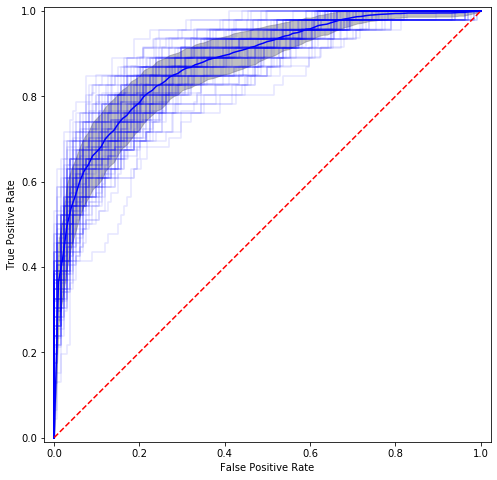

In [37]:
model_num = [i for i in range(5, 105, 5)] # 20 models are initialised
lr = LogisticRegression(random_state=100, class_weight='balanced', solver='liblinear')
lrscores = run_model(lr, model_num, X, Y)

In [38]:
# Scores of 100 runs
get_average_score(lrscores)

Metric: overall_acc, 0.81 +/- 0.003
Metric: f1, 0.67 +/- 0.005
Metric: roc_auc, 0.88 +/- 0.003
Metric: roc_pr, 0.78 +/- 0.004
Metric: class0_acc, 0.84 +/- 0.003
Metric: class1_acc, 0.75 +/- 0.006


/home/dlho/Software/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


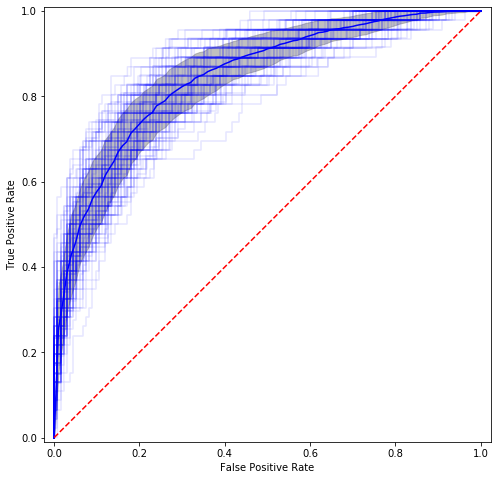

In [19]:
svm = SVC(kernel='rbf', random_state=100, gamma = 'scale', class_weight='balanced', probability=True)
svmscores= run_model(svm, model_num, X, Y)

In [20]:
get_average_score(svmscores)

Metric: overall_acc, 0.80 +/- 0.003
Metric: f1, 0.64 +/- 0.005
Metric: roc_auc, 0.85 +/- 0.003
Metric: roc_pr, 0.71 +/- 0.005
Metric: class0_acc, 0.84 +/- 0.003
Metric: class1_acc, 0.69 +/- 0.007


/home/dlho/Software/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


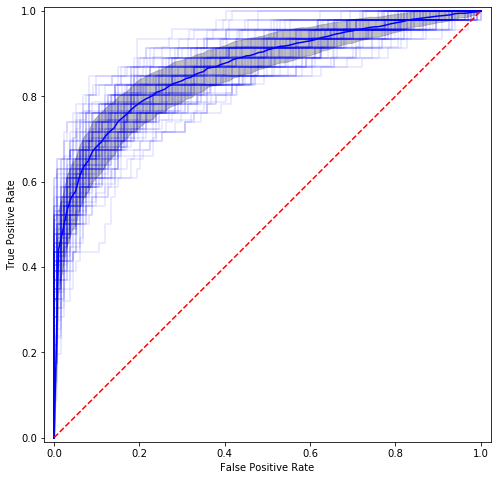

In [21]:
gb = GradientBoostingClassifier(random_state=100)
gbscores= run_model(gb, model_num, X, Y)

In [22]:
get_average_score(gbscores)

Metric: overall_acc, 0.85 +/- 0.002
Metric: f1, 0.67 +/- 0.005
Metric: roc_auc, 0.87 +/- 0.003
Metric: roc_pr, 0.79 +/- 0.004
Metric: class0_acc, 0.95 +/- 0.002
Metric: class1_acc, 0.59 +/- 0.007


/home/dlho/Software/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/dlho/Software/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


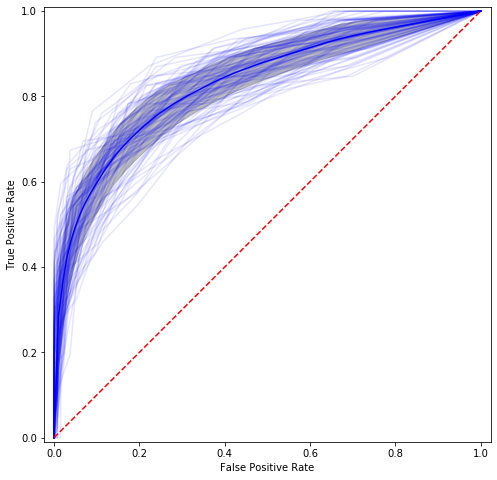

In [23]:
rf = RandomForestClassifier(random_state=100, class_weight='balanced')
rfscores= run_model(rf, model_num, X, Y)

In [24]:
get_average_score(rfscores)

Metric: overall_acc, 0.83 +/- 0.002
Metric: f1, 0.57 +/- 0.007
Metric: roc_auc, 0.83 +/- 0.003
Metric: roc_pr, 0.68 +/- 0.005
Metric: class0_acc, 0.96 +/- 0.002
Metric: class1_acc, 0.45 +/- 0.008


Baseline models isn't that great. You can tell that the models, especially the more complex ones, are not learning very well - they are generally overfitting to the majority class, even though we have already weighted the classes for most of our classifiers.  
Simple classifiers LR and SVM suffer less from the problem of overfitting.  
Overfitting can be combated by tuning the classifiers using GridSearch (such as https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html) or adaptive search with HyperOpt (http://hyperopt.github.io/hyperopt/). As our paper did not explore classifier tuning but embarked on the methods below instead for tackling imbalanced learning, we do not go through them but encourage the reader to explore these options.

# Machine Learning - Feature Selection

This is one way we can make the models learn better by reducing the dataset dimensionality and selecting for only most relevant features. We will select features that are most predictive for recurrence using mutual information.  
We demonstrate this on LR, our best classifier on this synthetic dataset.

In [39]:
# Import relevant libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from functools import partial

In [40]:
# Helper functions
def select_features(X, Y, num_feats):
    # This function selects the best features using the MI estimator
    return SelectKBest(partial(mutual_info_classif, random_state=100), k=num_feats).fit_transform(X, Y)
def get_best_score(scoredict, metric='roc_auc'):
    num_feats = []
    avg_scores = []
    for num_feat, scores in scoredict.items():
        avg_score = np.array(scores[metric]).mean()
        std_dev = np.array(scores[metric]).std()
        avg_scores.append(avg_score)
        num_feats.append(num_feat)
    max_avg_score_pos = avg_scores.index(max(avg_scores))
    best_feature_num = num_feats[max_avg_score_pos]
    print("Best number of features is %s with %s score of %s" %(best_feature_num, metric, max(avg_scores)))
    return best_feature_num

In [41]:
num_features = [i for i in range(10, 131, 10)]
scoredictlr = {}
for num_feat in num_features:
    X_selected = select_features(X, Y, num_feat)
    lr = LogisticRegression(random_state=100, class_weight='balanced', solver='liblinear', max_iter=1000)
    lrscores= run_model(lr, model_num, X_selected, Y, plot=0)
    scoredictlr[num_feat] = lrscores
best_feature_num = get_best_score(scoredictlr)

Best number of features is 30 with roc_auc score of 0.8958917314306934


In [42]:
get_average_score(scoredictlr[best_feature_num])

Metric: overall_acc, 0.84 +/- 0.003
Metric: f1, 0.71 +/- 0.004
Metric: roc_auc, 0.90 +/- 0.003
Metric: roc_pr, 0.81 +/- 0.004
Metric: class0_acc, 0.86 +/- 0.003
Metric: class1_acc, 0.77 +/- 0.005


Feature selection helps a lot, as we have shown in our paper. All metrics have improved over the baseline LR model!

# Machine Learning - Sampling techniques

We will use the package imbalanced-learn (documentation: https://imbalanced-learn.org/stable/) to perform under and over-sampling, and demonstrate its effects on LR, our best model so far

In [43]:
# Import relevant packages
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
tl = TomekLinks(return_indices=True)
smt = SMOTETomek(random_state=100)

Using TensorFlow backend.


In [45]:
# Change our run_model function to incorporate under and over-sampling
def run_model(clf, seeds, X, Y, filename=0, plot=1, sampling=0):
    scores = defaultdict(list)
    
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    
    if plot:
        plt.figure(figsize=(8, 8))

    for seed in seeds:
        # We use StratifiedKFold to give us the random split instead. 
        skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
        for train_index, test_index in skf.split(X, Y):

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]
            
            if sampling=='tomek':
                X_train, y_train, idx_undersamp = tl.fit_sample(X_train, y_train)
            elif sampling=='smotetomek':
                X_train, y_train = smt.fit_resample(X_train, y_train)
            else:
                pass

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yprob = clf.predict_proba(X_test) #probability estimates

            # Get metrics
            scores = scoring(clf, y_test, y_pred, yprob, scores)

            # Plot ROC curves
            fpr, tpr, _ = metrics.roc_curve(y_test, yprob[:, 1])
            
            if plot:
                plt.plot(fpr, tpr, 'b', alpha=0.1)
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    
    if plot:
        plt.plot(base_fpr, mean_tprs, 'b')
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.5)

        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.axes().set_aspect('equal', 'datalim')
    # Save file if filename is provided
    if filename:
        plt.savefig(filename)
        
    return scores

### Tomek only

In [53]:
lr = LogisticRegression(random_state=100, class_weight='balanced', solver='liblinear', max_iter=1000)
lrscores= run_model(lr, model_num, X, Y, plot=0, sampling='tomek')

In [54]:
get_average_score(lrscores)

Metric: overall_acc, 0.81 +/- 0.003
Metric: f1, 0.67 +/- 0.004
Metric: roc_auc, 0.88 +/- 0.003
Metric: roc_pr, 0.77 +/- 0.005
Metric: class0_acc, 0.82 +/- 0.004
Metric: class1_acc, 0.76 +/- 0.006


### Tomek + SMOTE

In [55]:
lr = LogisticRegression(random_state=100, class_weight='balanced', solver='liblinear', max_iter=1000)
lrscores= run_model(lr, model_num, X, Y, plot=0, sampling='smotetomek')

In [56]:
get_average_score(lrscores)

Metric: overall_acc, 0.82 +/- 0.003
Metric: f1, 0.67 +/- 0.005
Metric: roc_auc, 0.88 +/- 0.003
Metric: roc_pr, 0.78 +/- 0.004
Metric: class0_acc, 0.85 +/- 0.004
Metric: class1_acc, 0.73 +/- 0.006


### Feature selection + Tomek undersampling

In [49]:
X_selected = select_features(X, Y, best_feature_num)
lr = LogisticRegression(random_state=100, class_weight='balanced', solver='liblinear', max_iter=1000)
lrscores= run_model(lr, model_num, X_selected, Y, plot=0, sampling='tomek')

In [50]:
get_average_score(lrscores)

Metric: overall_acc, 0.83 +/- 0.003
Metric: f1, 0.70 +/- 0.004
Metric: roc_auc, 0.89 +/- 0.003
Metric: roc_pr, 0.81 +/- 0.004
Metric: class0_acc, 0.84 +/- 0.003
Metric: class1_acc, 0.78 +/- 0.006


### Feature selection + Tomek + SMOTE

In [51]:
X_selected = select_features(X, Y, best_feature_num)
lr = LogisticRegression(random_state=100, class_weight='balanced', solver='liblinear', max_iter=1000)
lrscores= run_model(lr, model_num, X_selected, Y, plot=0, sampling='smotetomek')

In [52]:
get_average_score(lrscores)

Metric: overall_acc, 0.83 +/- 0.002
Metric: f1, 0.70 +/- 0.004
Metric: roc_auc, 0.90 +/- 0.003
Metric: roc_pr, 0.82 +/- 0.004
Metric: class0_acc, 0.86 +/- 0.003
Metric: class1_acc, 0.76 +/- 0.006


Similar to our paper, we find that under and over-sampling techniques doesn't help us much for our dataset. The scores are roughly the same for Tomek, and regressed slightly when SMOTE is added, for simple classifiers such as LR.